Epoch 1 | Train: 0.004230 | Val: 0.003358
Epoch 2 | Train: 0.020508 | Val: 0.003147
Epoch 3 | Train: 0.003708 | Val: 0.002976
Epoch 4 | Train: 0.003461 | Val: 0.002847
Epoch 5 | Train: 0.003470 | Val: 0.002683
Epoch 6 | Train: 0.003650 | Val: 0.002849
Epoch 7 | Train: 0.002879 | Val: 0.002626
Epoch 8 | Train: 0.002975 | Val: 0.002627
Epoch 9 | Train: 0.002676 | Val: 0.002485
Epoch 10 | Train: 0.002563 | Val: 0.002423
Epoch 11 | Train: 0.002575 | Val: 0.002418
Epoch 12 | Train: 0.004653 | Val: 0.002500
Epoch 13 | Train: 0.002539 | Val: 0.002355
Epoch 14 | Train: 0.005024 | Val: 0.002398
Epoch 15 | Train: 0.002422 | Val: 0.002293
Epoch 16 | Train: 0.002492 | Val: 0.002603
Epoch 17 | Train: 0.002932 | Val: 0.002290
Epoch 18 | Train: 0.002391 | Val: 0.002266
Epoch 19 | Train: 0.002713 | Val: 0.002550
Epoch 20 | Train: 0.002367 | Val: 0.002238
Epoch 21 | Train: 0.002356 | Val: 0.002239
Epoch 22 | Train: 0.002452 | Val: 0.002355
Epoch 23 | Train: 0.002548 | Val: 0.002215
Epoch 24 | Train: 0.

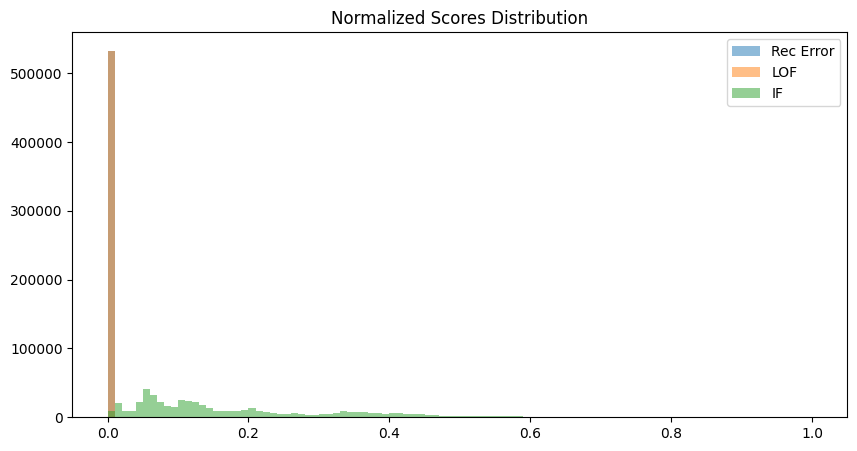

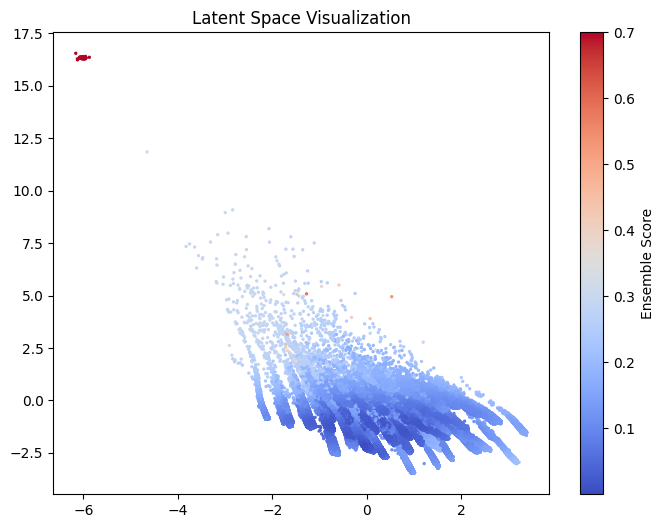

In [2]:
# =============================
# 0. Imports
# =============================
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from scipy import sparse

# =============================
# 1. Load dữ liệu
# =============================
data_path = "../data/raw/fraud_dataset_v1.csv"
df = pd.read_csv(data_path)
labels_orig = df['label'].values
df_features = df.drop(columns=['label'])

# =============================
# 2. Preprocessing (numeric + categorical, sparse)
# =============================
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
categorical_cols = df_features.select_dtypes(include=[object]).columns

# Chuẩn hóa numeric
df_numeric = StandardScaler().fit_transform(df_features[numeric_cols])

# One-hot encoding categorical (sparse)
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=True)
    df_cat = encoder.fit_transform(df_features[categorical_cols])
    X_sparse = sparse.hstack([sparse.csr_matrix(df_numeric), df_cat]).tocsr()
else:
    X_sparse = sparse.csr_matrix(df_numeric)

# =============================
# 3. Split train/val
# =============================
n_samples = X_sparse.shape[0]
train_size = int(0.8 * n_samples)
val_size = n_samples - train_size

# Chuyển sparse -> dense batch khi cần, tránh MemoryError
X_dense = X_sparse.astype(np.float32).toarray()  # dense toàn bộ dataset

train_dataset, val_dataset = random_split(torch.from_numpy(X_dense), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

# =============================
# 4. Autoencoder
# =============================
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

input_dim = X_dense.shape[1]
latent_dim = 3
ae = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

# Early stopping
best_val_loss = np.inf
patience = 5
counter = 0
best_model_state = None

for epoch in range(50):
    ae.train()
    train_loss = 0
    for batch in train_loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, _ = ae(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)

    ae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x_batch = batch[0]
            x_hat, _ = ae(x_batch)
            loss = criterion(x_hat, x_batch)
            val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = ae.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

ae.load_state_dict(best_model_state)

# =============================
# 5. Compute reconstruction error & latent vectors (batch)
# =============================
batch_size = 1024
rec_errors = []
latent_vectors_list = []

ae.eval()
with torch.no_grad():
    for i in range(0, X_dense.shape[0], batch_size):
        batch = X_dense[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch)
        X_hat_batch, Z_batch = ae(batch_tensor)
        rec_errors.append(((batch_tensor - X_hat_batch)**2).mean(dim=1).numpy())
        latent_vectors_list.append(Z_batch.numpy())

rec_error = np.concatenate(rec_errors)
latent_vectors = np.concatenate(latent_vectors_list)

# =============================
# 6. LOF & IF scores
# =============================
lof = LocalOutlierFactor(n_neighbors=5, novelty=True)
lof.fit(latent_vectors)
lof_scores = -lof.decision_function(latent_vectors)

if_model = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
if_model.fit(latent_vectors)
if_scores = -if_model.score_samples(latent_vectors)

# =============================
# 7. Normalize ensemble scores
# =============================
scores_stack = np.vstack([rec_error, lof_scores, if_scores]).T
scores_norm = MinMaxScaler().fit_transform(scores_stack)
rec_error_norm, lof_scores_norm, if_scores_norm = scores_norm[:,0], scores_norm[:,1], scores_norm[:,2]

alpha, beta, gamma = 0.4, 0.3, 0.3
ensemble_score = alpha*rec_error_norm + beta*lof_scores_norm + gamma*if_scores_norm

# =============================
# 8. Threshold selection
# =============================
best_thresh = np.percentile(ensemble_score, 99.97)
preds = (ensemble_score >= best_thresh).astype(int)

# =============================
# 9. Evaluation với nhãn thật
# =============================
label_map = {"regular": 0, "local": 1, "global": 1}
labels_numeric = np.array([label_map[l] if isinstance(l, str) else int(l) for l in labels_orig])

print("Threshold used:", best_thresh)
print("Anomalies predicted #:", np.sum(preds))
print("Anomalies predicted %: {:.2f}%".format(np.sum(preds)/len(preds)*100))
print("Precision:", precision_score(labels_numeric, preds))
print("Recall:", recall_score(labels_numeric, preds))
print("F1-score:", f1_score(labels_numeric, preds))
print("ROC-AUC:", roc_auc_score(labels_numeric, ensemble_score))

anomalies_by_label = df[preds==1]["label"].value_counts()
print("Anomalies predicted by original label:")
print(anomalies_by_label)

# =============================
# 10. Lưu kết quả dataset
# =============================
df["predicted_anomaly"] = preds
df.to_csv("../src/results_full/dataset_with_predictions.csv", index=False)
print("Dataset with predictions saved as 'dataset_with_predictions.csv'")

# =============================
# 11. Visualization
# =============================
plt.figure(figsize=(10,5))
plt.hist(rec_error_norm, bins=100, alpha=0.5, label="Rec Error")
plt.hist(lof_scores_norm, bins=100, alpha=0.5, label="LOF")
plt.hist(if_scores_norm, bins=100, alpha=0.5, label="IF")
plt.legend()
plt.title("Normalized Scores Distribution")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=ensemble_score, cmap='coolwarm', s=2)
plt.colorbar(label='Ensemble Score')
plt.title("Latent Space Visualization")
plt.show()
